In [ ]:
import os
import warnings

import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Colab에서 이용하실 때는 "pip install torchmeta"을 이용하여 torchmeta를 설치해주세요.
from torchmeta.datasets.helpers import omniglot
from torchmeta.modules import (
    MetaBatchNorm2d,
    MetaConv2d,
    MetaLinear,
    MetaModule,
    MetaSequential,
)
from torchmeta.utils.data import BatchMetaDataLoader
from torchmeta.utils.gradient_based import gradient_update_parameters
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [ ]:
def get_dataloader(args):
    train_dataset = omniglot(
        args.folder,
        shots=args.num_shots,
        # test_shots=1, # default = shots
        ways=args.num_ways,
        shuffle=True,
        meta_train=True,
        download=args.download,
    )
    train_dataloader = BatchMetaDataLoader(
        train_dataset, batch_size=args.task_batch_size, shuffle=True, num_workers=1
    )

    test_dataset = omniglot(
        args.folder,
        shots=args.num_shots,
        # test_shots=1, # default = shots
        ways=args.num_ways,
        shuffle=True,
        meta_test=True,
        download=args.download,
    )
    test_dataloader = BatchMetaDataLoader(
        test_dataset, batch_size=args.task_batch_size, shuffle=True, num_workers=1
    )

    val_dataset = omniglot(
        args.folder,
        shots=args.num_shots,
        # test_shots=1, # default = shots
        ways=args.num_ways,
        shuffle=True,
        meta_val=True,
        download=args.download,
    )
    val_dataloader = BatchMetaDataLoader(
        val_dataset, batch_size=args.task_batch_size, shuffle=True, num_workers=1
    )

    return train_dataloader, test_dataloader, val_dataloader

In [ ]:
def save_model(args, model, title):
    if not os.path.isdir(args.output_folder):
        os.mkdir(args.output_folder)
    filename = os.path.join(args.output_folder, title)
    with open(filename, "wb") as f:
        state_dict = model.state_dict()
        torch.save(state_dict, f)
    print("model saved in", filename)


def load_model(args, model, title):
    filename = os.path.join(args.output_folder, title)
    model.load_state_dict(torch.load(filename))
    print("Load model from ", filename)

In [ ]:
def print_graph(train_accuracies, val_accuracies, train_losses, val_losses):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    axs[0].plot(train_accuracies, label="train_acc")
    axs[0].plot(val_accuracies, label="val_acc")
    axs[0].set_title("Accuracy")
    axs[0].legend()

    axs[1].plot(train_losses, label="train_loss")
    axs[1].plot(val_losses, label="val_loss")
    axs[1].set_title("Loss")
    axs[1].legend()

    fig.show()

In [ ]:
class ConvNet(MetaModule):
    def __init__(self, in_channels, out_features):
        super(ConvNet, self).__init__()
        self.in_channels = in_channels
        self.out_features = out_features
        self.hidden_size = 64

        self.convs = MetaSequential(
            self.convBlock(self.in_channels, self.hidden_size, 3),
            self.convBlock(self.hidden_size, self.hidden_size, 3),
            self.convBlock(self.hidden_size, self.hidden_size, 3),
            self.convBlock(self.hidden_size, self.hidden_size, 3),
        )

        self.linear = MetaLinear(self.hidden_size, self.out_features)

    def convBlock(self, in_channels, out_channels, kernel_size, **kwargs):
        return MetaSequential(
            MetaConv2d(in_channels, out_channels, kernel_size, padding=1, stride=3, **kwargs),
            MetaBatchNorm2d(out_channels, momentum=1.0, track_running_stats=False),
            nn.ReLU(),
        )

    def forward(self, x, params=None):
        x_convs = self.convs(x, params=self.get_subdict(params, "convs"))
        prob = self.linear(x_convs.flatten(start_dim=1), params=self.get_subdict(params, "linear"))
        return prob

In [ ]:
def train_MAML(args, task_batch, model, criterion, optimizer):
    model.train()

    support_xs = task_batch["train"][0].to(device=args.device)
    support_ys = task_batch["train"][1].to(device=args.device)
    query_xs = task_batch["test"][0].to(device=args.device)
    query_ys = task_batch["test"][1].to(device=args.device)

    outer_loss = torch.tensor(0.0, device=args.device)
    accuracy = torch.tensor(0.0, device=args.device)

    for task_idx, (support_x, support_y, query_x, query_y) in enumerate(
        zip(support_xs, support_ys, query_xs, query_ys)
    ):
        support_prob = model(support_x)
        inner_loss = criterion(support_prob, support_y)

        params = gradient_update_parameters(model, inner_loss, step_size=0.4, first_order=True)

        query_prob = model(query_x, params=params)
        outer_loss += criterion(query_prob, query_y)

        with torch.no_grad():
            _, query_pred = torch.max(query_prob, dim=-1)
            accuracy += torch.mean(query_pred.eq(query_y).float())

    outer_loss.div_(args.task_batch_size)

    model.zero_grad()
    outer_loss.backward()
    optimizer.step()

    accuracy.div_(args.task_batch_size)

    return accuracy.item(), outer_loss.item()

In [ ]:
def test_MAML(args, task_batch, model, criterion, optimizer):
    model.eval()

    support_xs = task_batch["train"][0].to(device=args.device)
    support_ys = task_batch["train"][1].to(device=args.device)
    query_xs = task_batch["test"][0].to(device=args.device)
    query_ys = task_batch["test"][1].to(device=args.device)

    outer_loss = torch.tensor(0.0, device=args.device)
    accuracy = torch.tensor(0.0, device=args.device)

    for task_idx, (support_x, support_y, query_x, query_y) in enumerate(
        zip(support_xs, support_ys, query_xs, query_ys)
    ):
        support_prob = model(support_x)
        inner_loss = criterion(support_prob, support_y)

        params = gradient_update_parameters(model, inner_loss, step_size=0.4, first_order=True)

        query_prob = model(query_x, params=params)
        outer_loss += criterion(query_prob, query_y)

        with torch.no_grad():
            _, query_pred = torch.max(query_prob, dim=-1)
            accuracy += torch.mean(query_pred.eq(query_y).float())

    outer_loss.div_(args.task_batch_size)
    accuracy.div_(args.task_batch_size)

    return accuracy.item(), outer_loss.item()

In [ ]:
args = {
    "folder": "dataset",
    "download": True,
    "num_shots": 5,
    "num_ways": 5,
    "output_folder": "model",
    "task_batch_size": 32,  # 필수
    "num_task_batch_train": 600,  # 필수
    "num_task_batch_test": 200,  # 필수
    "device": "cuda",  # 필수
}

train_dataloader, test_dataloader, val_dataloader = get_dataloader(args)
model = ConvNet(1, args.num_ways).to(device=args.device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

100%|██████████| 600/600 [11:27<00:00,  1.15s/it, train_accuracy=0.9200, train_loss=0.2512, val_accuracy=0.9162, val_loss=0.2327]


model saved in model/maml_classification.th


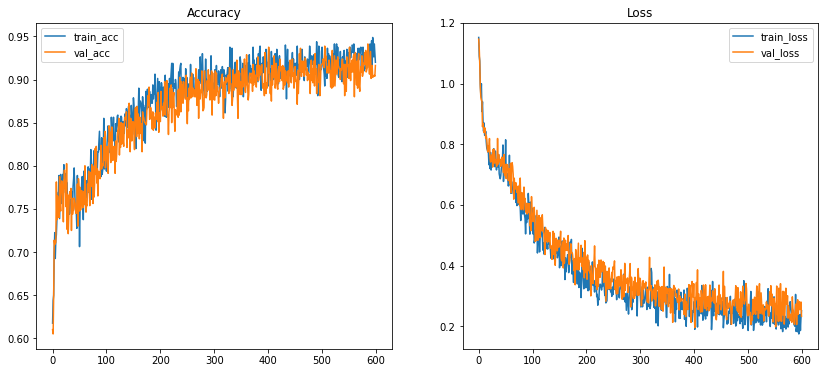

In [ ]:
# Training loop
with tqdm(zip(train_dataloader, val_dataloader), total=args.num_task_batch_train) as pbar:
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    for task_batch_idx, (train_batch, val_batch) in enumerate(pbar):
        if task_batch_idx >= args.num_task_batch_train:
            break

        train_accuracy, train_loss = train_MAML(args, train_batch, model, criterion, optimizer)
        val_accuracy, val_loss = test_MAML(args, val_batch, model, criterion, optimizer)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        pbar.set_postfix(
            train_accuracy="{0:.4f}".format(train_accuracy),
            val_accuracy="{0:.4f}".format(val_accuracy),
            train_loss="{0:.4f}".format(train_loss),
            val_loss="{0:.4f}".format(val_loss),
        )

# save model
save_model(args, model, "MAML_classification.th")
print_graph(train_accuracies, val_accuracies, train_losses, val_losses)

In [ ]:
# load model
load_model(args, model, "MAML_classification.th")

# Testing loop
with tqdm(test_dataloader, total=args.num_task_batch_test) as pbar:
    sum_test_accuracies = 0.0
    sum_test_losses = 0.0

    for task_batch_idx, test_batch in enumerate(pbar):
        if task_batch_idx >= args.num_task_batch_test:
            break

        test_accuracy, test_loss = test_MAML(args, test_batch, model, criterion, optimizer)

        sum_test_accuracies += test_accuracy
        sum_test_losses += test_loss
        pbar.set_postfix(
            test_accuracy="{0:.4f}".format(sum_test_accuracies / (task_batch_idx + 1)),
            test_loss="{0:.4f}".format(sum_test_losses / (task_batch_idx + 1)),
        )

Load model from  model/maml_classification.th


100%|██████████| 200/200 [02:28<00:00,  1.35it/s, test_accuracy=0.9014, test_loss=0.2938]
